**Importing Necessary Libraries**

In [1]:
import re
import pandas as pd
import numpy as np
import nltk

In [ ]:
from nltk.corpus import stopwords

**Fetching the data** (the data has been preprocessed already)

Preprocessing steps include: 
1. Lemmatization
2. Stop Word Removal
3. Removing html tags and urls

In [1]:
from google.colab import files
data = files.upload()

Saving Final_data.csv to Final_data.csv


In [2]:
data = pd.read_csv('Final_data.csv')

**Preparing the data**

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
reviews = data['Reviews'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [7]:
max_length = 500
embedding_dim = 50

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
tokenizer = Tokenizer(lower=False, split=' ', oov_token=None, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(reviews)
X_vocab = {"<PAD>":0}
X_vocab.update(tokenizer.word_index)


all_text2seq= tokenizer.texts_to_sequences(reviews)

padded_seq = pad_sequences(all_text2seq,  maxlen=500, padding="post", truncating="post")

In [12]:
X_train, X_test, train_labels, test_labels = train_test_split(padded_seq, encoded_labels, stratify = encoded_labels)

**Creating the model architecture**

In [15]:
import tensorflow as tf
import keras
from keras.layers import Input, Conv1D, MaxPooling1D, Embedding, Dense, Flatten, Dropout
from keras import Model

In [16]:
import gensim.downloader as api
nlp = api.load("glove-twitter-25")

In [17]:
X_embeddings = np.zeros((len(X_vocab)+1, 300)) 
for word,idx in X_vocab.items():
    ## update the row with vector
    try:
        X_embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [18]:
#Model architecture

input = Input(shape=(max_length,))
#input.shape = TensorShape([None, 500])

embedding_lyr =Embedding(len(X_vocab), embedding_dim)(input)
#embedding_lyr.shape = TensorShape([None, 500, 50])

lyr1 = Conv1D(32,3,activation = 'relu')(embedding_lyr)
#lyr1.shape = TensorShape([None, 498, 32])

lyr2 = MaxPooling1D(2)(lyr1)
#lyr2.shape = TensorShape([None, 249, 32])

lyr3 = Dropout(0.3)(lyr2)
#lyr3.shape = TensorShape([None, 249, 32])

lyr4 = Conv1D(32,3,activation = 'relu')(lyr3)
#lyr4.shape = TensorShape([None, 247, 32])

lyr5 = MaxPooling1D(2)(lyr4)
#lyr5.shape = TensorShape([None, 123, 32])

lyr6 = Dropout(0.3)(lyr5)
#lyr6.shape = TensorShape([None, 123, 32])

lyr7 = Flatten()(lyr6)
#lyr7.shape = TensorShape([None, 3936])

lyr8 = Dense(1000, activation = 'relu')(lyr7)
#lyr8.shape = TensorShape([None, 1000])

lyr9 = Dense(100, activation = 'relu')(lyr8)
#lyr9.shape = TensorShape([None, 100])

pred = Dense(1, activation = 'sigmoid')(lyr9)
#pred.shape = TensorShape([None, 1])


In [19]:
cnn_model = Model(input, pred)
cnn_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
cnn_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 50)           4577900   
                                                                 
 conv1d (Conv1D)             (None, 498, 32)           4832      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 249, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 247, 32)           3104      
                                                             

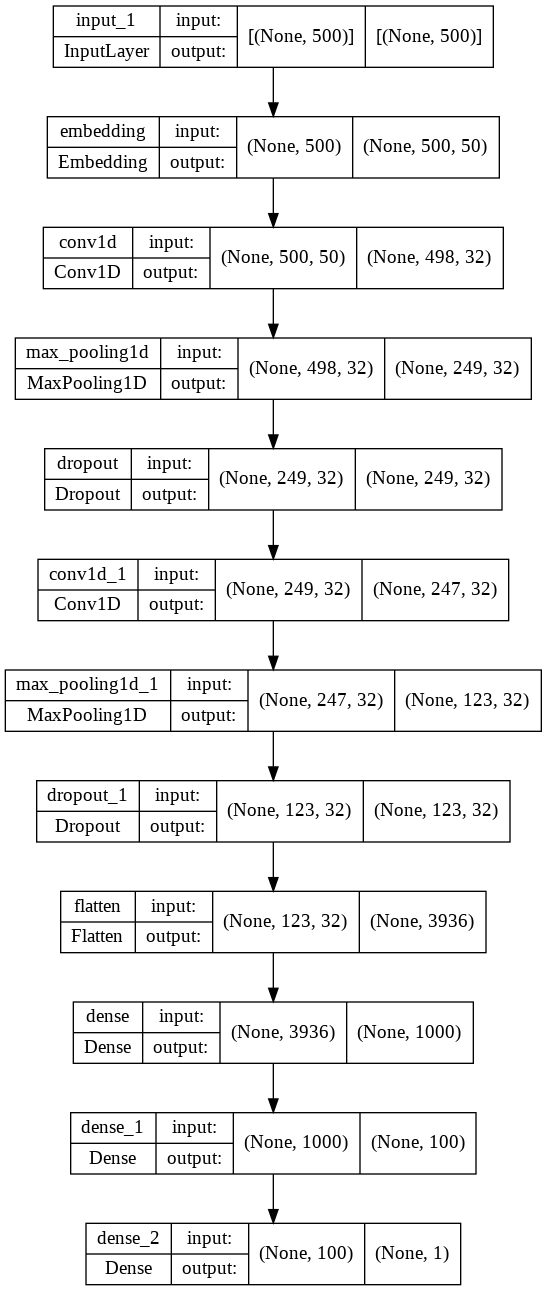

In [21]:
tf.keras.utils.plot_model(
    cnn_model,
    to_file="cnn_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

**Training**

In [22]:
import h5py

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 200)
mcp = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

In [25]:
num_epochs = 20
history = cnn_model.fit(X_train, train_labels, 
                    epochs=num_epochs, validation_data = ([X_test[:6250]], [test_labels[:6250]]), callbacks = [es,mcp])

Epoch 1/20
1172/1172 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8279
Epoch 1: val_accuracy improved from -inf to 0.87984, saving model to best_model.h5
1172/1172 [==============================] - 124s 105ms/step - loss: 0.3640 - accuracy: 0.8279 - val_loss: 0.2914 - val_accuracy: 0.8798
Epoch 2/20
1172/1172 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.9157
Epoch 2: val_accuracy improved from 0.87984 to 0.90448, saving model to best_model.h5
1172/1172 [==============================] - 121s 104ms/step - loss: 0.2249 - accuracy: 0.9157 - val_loss: 0.2443 - val_accuracy: 0.9045
Epoch 3/20
1172/1172 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9324
Epoch 3: val_accuracy improved from 0.90448 to 0.90640, saving model to best_model.h5
1172/1172 [==============================] - 122s 104ms/step - loss: 0.1869 - accuracy: 0.9324 - val_loss: 0.2518 - val_accuracy: 0.9064
Epoch 4/20
1172/1172 [==================

**Learning Curves**

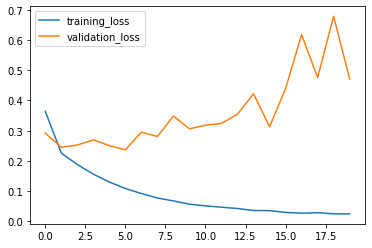

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

**Predictions on the test data (unseen data)**

In [27]:
from keras.models import load_model

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score, f1_score

In [28]:
# load the saved model (best model)
saved_model = load_model('best_model.h5')

In [30]:
prediction = saved_model.predict(X_test[6250:])
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels[6250:],pred_labels))


Accuracy of prediction on test set :  0.91168


In [38]:
print(classification_report(test_labels[6250:],pred_labels))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3124
           1       0.91      0.91      0.91      3126

    accuracy                           0.91      6250
   macro avg       0.91      0.91      0.91      6250
weighted avg       0.91      0.91      0.91      6250



In [40]:
f = fbeta_score(test_labels[6250:],pred_labels, beta=2)
f

0.913738019169329

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [35]:
cf_matrix = confusion_matrix(test_labels[6250:], pred_labels)
print(cf_matrix)

[[2838  286]
 [ 266 2860]]


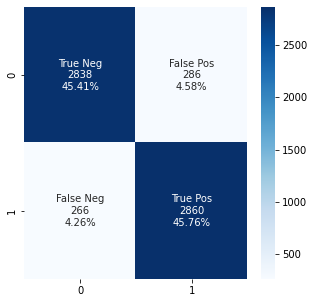

In [37]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)


sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [42]:
from sklearn.metrics import roc_auc_score

In [43]:
roc_score = roc_auc_score(test_labels[6250:],pred_labels)
roc_score

0.9116789669559262